# Calibration notebook for "Fiscal and Monetary Policy with Heterogeneous Agents"
This notebook calibrates the heterogeneous-agent (HA) household model used in the paper, and produces Figures 1(a) and 1(b).

It imports the specific heterogeneous-agent household block that we use, along with exogenously calibrated parameters and initial guesses, from the `household.py` module, which is included in this same repository.

It outputs the optimized calibration parameters in human-readable form to `hh_params.json`, which is then taken as an input by the `Annual Review main.ipynb` notebook that does the rest of the computations for the paper.

Start with preliminary imports:

In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import json

from household import (hh_ha as hh,
                       calibration_ha as calibration)

Uncomment the second line below if you want plots with exactly the same style as in the paper (note that this may take longer to render or have compatibility issues):

In [2]:
plt.rcParams.update({'font.size': 10, 'font.family': 'serif', 'figure.figsize': (4, 3)})
# plt.rcParams.update({'text.usetex': True, 'font.serif': 'Palatino'})

# 1. Main HA calibration

First, our aggregate asset and MPC targets:

In [3]:
A_target = 20 # target 500% of annual GDP assets, or 2000% of quarterly GDP
mpc_target = 0.20 # target quarterly MPC out of labor income of 20%

Load Lorenz curve from the SCF and precalculate it interpolated at percentiles 0, 0.01, ...

In [4]:
lorenz_scf_raw = np.loadtxt('inputs/lorenz_nw_scf_2019.raw', delimiter=',')

percentiles = np.arange(101) / 100
lorenz_scf = np.array([np.interp(pctl, lorenz_scf_raw[:, 0], lorenz_scf_raw[:, 1]) for pctl in percentiles])

Function for calculating Lorenz curve at some percentiles from model's steady state:

In [5]:
def get_lorenz(ss, percentiles):
    D = ss.internals['hh_ha']['D'].sum(axis=0) # distribution over asset grid alone
    a_grid = ss.internals['hh_ha']['a_grid']
    lorenz_model = np.array([np.interp(pctl, D.cumsum(), (a_grid * D).cumsum()) / ss['A'] for pctl in percentiles])
    return lorenz_model

Code that evaluates a proposed calibration and reports errors on our three calibration criteria: aggregate assets, impact MPC out of labor income, and average error in Lorenz curve.

In [6]:
def evaluate_calibration(x):
    print(x)
    ss = hh.steady_state(calibration | dict(beta_hi=x[0], dbeta=x[1], omega=x[2]))
    mpc_labor = hh.jacobian(ss, inputs=['wN_aftertax'], outputs=['C'], T=2)['C', 'wN_aftertax'][0, 0]
    lorenz_model = get_lorenz(ss, percentiles)
    return ss['A'] - A_target, mpc_labor - mpc_target, (lorenz_model - lorenz_scf).sum()

In [7]:
x0 = np.array([1, 0.08, 0.5])
res = optimize.root(evaluate_calibration, x0)

[1.   0.08 0.5 ]
[1.   0.08 0.5 ]
[1.   0.08 0.5 ]
[1.00000001 0.08       0.5       ]
[1.   0.08 0.5 ]
[1.         0.08       0.50000001]
[0.99934193 0.1085165  0.50109153]
[0.99964583 0.0777377  0.45848077]
[0.99931734 0.0747151  0.4599688 ]
[0.99855609 0.09522062 0.49671442]
[0.99884949 0.07957661 0.47794855]
[0.99864178 0.09082481 0.49667821]
[0.99879434 0.08482649 0.48603308]
[0.99877555 0.08644988 0.48854409]
[0.99871222 0.0925305  0.49661495]
[0.99876758 0.08763382 0.48995549]
[0.99874098 0.08966614 0.49265   ]
[0.99876207 0.0879167  0.49040055]
[0.99876759 0.08763382 0.48995549]
[0.99876758 0.08763382 0.48995549]
[0.99876758 0.08763382 0.48995549]
[0.99876033 0.08810794 0.4906216 ]
[0.99876588 0.08766202 0.49007436]
[0.99876463 0.08784476 0.49023102]
[0.9987609  0.08806323 0.49056574]
[0.99876355 0.08781619 0.49028459]
[0.99876465 0.08784476 0.49023102]
[0.99876463 0.08784476 0.49023102]
[0.99876463 0.08784476 0.49023103]
[0.99876344 0.08786038 0.49031038]
[0.99876287 0.08786015

Check success, save results, and display $\beta^H$, $\beta^L$, and the share $\omega$ of patient:

In [8]:
assert res.success
beta_hi, dbeta, omega = res.x
print(beta_hi, beta_hi - dbeta, omega)

0.9987628713512855 0.9109027223893595 0.49034511183759133


In [9]:
calibration_full = calibration | dict(beta_hi=beta_hi, dbeta=dbeta, omega=omega)
calibration_full['beta_ave'] = beta_hi - (1-omega)*dbeta # will need average beta for Phillips curve later

ss = hh.steady_state(calibration_full)
print(ss['A'])

20.00000000001014


In [10]:
with open('hh_params.json', 'w') as f:
    json.dump(calibration_full, f, indent=4)

# 2. Main plots
### Figure 1b: Wealth distribution versus data
Load richer set of percentiles for a nicer plot:

In [11]:
percentiles_detail = np.arange(501) / 500
lorenz_scf_detail = np.array([np.interp(pctl, lorenz_scf_raw[:, 0], lorenz_scf_raw[:, 1]) for pctl in percentiles_detail])
lorenz_model_detail = get_lorenz(ss, percentiles_detail)

Compare at specified percentiles:

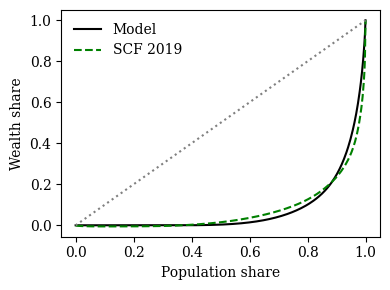

In [12]:
plt.plot(percentiles_detail, lorenz_model_detail, label='Model', color='black')
plt.plot(percentiles_detail, lorenz_scf_detail, label='SCF 2019', linestyle='dashed', color='green')
plt.plot([0, 1], [0, 1], linestyle='dotted', color='gray')
plt.ylabel('Wealth share')
plt.xlabel('Population share')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('figures/figure1b_lorenz.pdf')

### Figure 1a: intertemporal MPC comparison

In [13]:
T = 26
M_labor = hh.jacobian(ss, inputs=['wN_aftertax'], outputs=['C'], T=T)['C','wN_aftertax']
m_capital = hh.jacobian(ss, inputs=['r'], outputs=['C'], T=T)['C','r'][:, 0] / ss['A']

In [14]:
impcs = M_labor[:, 0]

# analytical formula for RA iMPCs, see e.g. Intertemporal Keynesian Cross paper
# (use analytical formulas rather than SSJ toolkit because toolkit default assumes 
# return to steady state, which is not true in partial equilibrium for RA model)
impcs_ra = ss['r'] / (1 + ss['r']) * np.ones(T)

# TA impcs are lam (hand to mouth share) times identity, plus (1-lam) times RA impcs
lam = mpc_target - ss['r'] / (1 + ss['r']) # hit same MPC with TA
impcs_ta = lam * (np.arange(T) == 0) + (1-lam) * impcs_ra

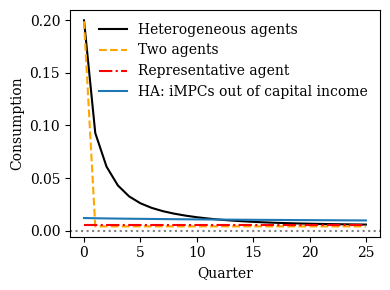

In [15]:
plt.plot(impcs[:T], label='Heterogeneous agents', color='black')
plt.plot(impcs_ta[:T], label='Two agents', linestyle='dashed', color='orange')
plt.plot(impcs_ra[:T], label='Representative agent', linestyle='dashdot', color='red')
plt.plot(m_capital[:T], label='HA: iMPCs out of capital income')
plt.axhline(y=0, linestyle='dotted', color='gray')
plt.legend(frameon=False)
plt.xlabel('Quarter')
plt.ylabel('Consumption')
plt.tight_layout()
plt.savefig('figures/figure1a_impcs.pdf')

# 3. Calculate unweighted MPCs as well
On impact, the average quarterly MPC unweighted by income is about 0.29. We calculate this by looking at the Jacobian with respect to a uniform lump-sum transfer.

In [16]:
M_unweighted = hh.jacobian(ss, inputs=['Tr_lumpsum'], outputs=['C'], T=5)['C','Tr_lumpsum']
M_unweighted.round(3)

array([[0.289, 0.095, 0.065, 0.048, 0.038],
       [0.091, 0.251, 0.073, 0.051, 0.039],
       [0.055, 0.071, 0.238, 0.064, 0.044],
       [0.037, 0.044, 0.063, 0.233, 0.06 ],
       [0.026, 0.03 , 0.039, 0.059, 0.229]])

Slightly below 50% is spent in the first year:

In [17]:
(1+ss['r'])**(-np.arange(4)) @ M_unweighted[:4, 0]

np.float64(0.46997266144818695)